In [11]:
# load 'p2_processed_chunks' parquets into one dataframe:


import dask.dataframe as dd

# Path to your directory containing the Parquet files
parquet_directory = 'p2_processed_chunks/'

# Read all Parquet files into a Dask DataFrame
dask_df = dd.read_parquet(parquet_directory + 'part.*.parquet')

pandas_df = dask_df.compute()

# Save the Pandas DataFrame to a single CSV file
output_csv_path = 'p3_post_combined.csv'

# drop 'cleaned_content' and 'content':
pandas_df.drop(columns=['cleaned_content', 'content'], inplace=True)

pandas_df.to_csv(output_csv_path, index=False)

print("Combined CSV file has been created.")

Combined CSV file has been created.


In [12]:
# Load p3_post_combined.csv:
import pandas as pd
data = pd.read_csv('p3_post_combined.csv')


In [13]:
# Let's separate the data into fake, junk, and real news. We use "type" column to do this.
# We print every type and the number of articles in that type:
print(data['type'].value_counts())

type
reliable      210264
political     187887
bias          128563
fake          101463
conspiracy     93969
rumor          54084
unknown        42062
unreliable     31554
clickbait      26470
junksci        13589
satire         12711
hate            8467
Name: count, dtype: int64


In [14]:
# Fake news will be all news that are bias, fake, conspiracy, hate
fake_news = data[(data['type'] == 'bias') | (data['type'] == 'fake') | (data['type'] == 'conspiracy') | (data['type'] == 'hate')]
# Junk news will be all news that are rumor, clickbait, junksci, unreliable
junk_news = data[(data['type'] == 'rumor') | (data['type'] == 'clickbait') | (data['type'] == 'junksci') | (data['type'] == 'unreliable')]
# real news are reliable and political:
real_news = data[(data['type'] == 'reliable') | (data['type'] == 'political')]
# The rest (unknown, satire) will be ignored as they are not clearly fake or real news and may pollute the data.

# We print the number of articles in each type:
print('Fake news:', len(fake_news))
print('Junk news:', len(junk_news))
print('Real news:', len(real_news))

Fake news: 332462
Junk news: 125697
Real news: 398151


In [15]:
# Calculate the vocabulary size of each type:

from collections import Counter

def compute_vocabulary(data):
    vocabulary = Counter()
    for text in data['tokens']:
        #if text is a float, print it:
        if isinstance(text, float):
            print(text)
            # this is nan, so we skip it
            continue
        words = text.split()
        vocabulary.update(words)
    return vocabulary

fake_vocabulary = compute_vocabulary(fake_news)
junk_vocabulary = compute_vocabulary(junk_news)
real_vocabulary = compute_vocabulary(real_news)

print('Fake news vocabulary size:', len(fake_vocabulary))
print('Junk news vocabulary size:', len(junk_vocabulary))
print('Real news vocabulary size:', len(real_vocabulary))

nan
nan
nan
nan
Fake news vocabulary size: 497362
Junk news vocabulary size: 241347
Real news vocabulary size: 522322


In [16]:
# Print the 10 most common words in each type:
print('Fake news:', fake_vocabulary.most_common(10))
print('Junk news:', junk_vocabulary.most_common(10))
print('Real news:', real_vocabulary.most_common(10))

Fake news: [('.', 7255613), (',', 7241601), ('<num>', 2437505), ('"', 2405359), ("'", 2181362), ('-', 1588930), (':', 815113), (')', 738522), ('(', 723807), ('?', 385315)]
Junk news: [('.', 2108238), (',', 1969142), ('<num>', 937232), ('-', 888033), ('"', 754875), ("'", 706942), (':', 234206), (')', 194784), ('(', 189294), ('said', 129706)]
Real news: [('.', 12768889), (',', 11636256), ("'", 5108210), ('<num>', 4070410), ('"', 3822071), ('-', 3111312), (':', 1109332), (')', 864812), ('(', 857450), ('said', 843825)]


In [1]:
data_vocabulary = compute_vocabulary(data)
rare_words = [word for word, count in data_vocabulary.items() if count < 5]

NameError: name 'compute_vocabulary' is not defined

In [2]:
# Count how many words in the whole dataset have less than 5 occurances:
import pandas as pd
data = pd.read_csv('p3_post_combined.csv')
print("Read data")

from collections import Counter


def compute_vocabulary(data):
    vocabulary = Counter()
    for text in data['tokens']:
        if isinstance(text, float):
            print(text)
            continue
        words = text.split()
        vocabulary.update(words)
    return vocabulary

data_vocabulary = compute_vocabulary(data)
rare_words = [word for word, count in data_vocabulary.items() if count < 5]

print('Number of words with less than 5 occurances:', len(rare_words))
print("Total vocabulary size:", len(data_vocabulary))

# Since the above will take too long, we're gonna use dask on the parquets. We'll load the parquets and then apply the function to them:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=16, threads_per_worker=1, memory_limit='4GB')
client = Client(cluster)


import dask.dataframe as dd

# Path to your directory containing the Parquet files
parquet_directory = 'p2_processed_chunks/'

# Read all Parquet files into a Dask DataFrame
dask_df = dd.read_parquet(parquet_directory + 'part.*.parquet')

# Create new column for tokens without rare words called rich_tokens:
def remove_rare_words(tokens, rare):
    words = tokens.split()
    words = [word for word in words if word not in rare]
    return ' '.join(words)

# Load the rare words:
#rare_words = pd.read_csv('rare_words.csv')['rare_words'].tolist()
rare_words_set = set(rare_words)

# Apply the function to the dask dataframe:
dask_df['rich_tokens'] = dask_df['tokens'].apply(remove_rare_words, rare=rare_words_set, meta=('tokens', 'str'))

# Save the dask dataframe to a new parquet:
dask_df.to_parquet('p4_rich_tokens.parquet')

print("Rich tokens have been created.")




Read data
nan
nan
nan
nan
Number of words with less than 5 occurances: 764031
Total vocabulary size: 998495
Rich tokens have been created.


In [3]:
# Look at rich tokens:
import pandas as pd
rich_data = pd.read_parquet('p4_rich_tokens.parquet')

# Calculate the vocabulary size of each type:

from collections import Counter

def compute_vocabulary(data):
    vocabulary = Counter()
    for text in data['rich_tokens']:
        if isinstance(text, float):
            print(text)
            continue
        words = text.split()
        vocabulary.update(words)
    return vocabulary

rich_vocabulary = compute_vocabulary(rich_data)

print('Rich vocabulary size:', len(rich_vocabulary))


Rich vocabulary size: 234464


In [4]:
# Now we can calculate the vocabulary size of each type:
fake_news = rich_data[(rich_data['type'] == 'bias') | (rich_data['type'] == 'fake') | (rich_data['type'] == 'conspiracy') | (rich_data['type'] == 'hate')]
junk_news = rich_data[(rich_data['type'] == 'rumor') | (rich_data['type'] == 'clickbait') | (rich_data['type'] == 'junksci') | (rich_data['type'] == 'unreliable')]
real_news = rich_data[(rich_data['type'] == 'reliable') | (rich_data['type'] == 'political')]
print('Fake news:', len(fake_news))
print('Junk news:', len(junk_news))
print('Real news:', len(real_news))

fake_vocabulary = compute_vocabulary(fake_news)
junk_vocabulary = compute_vocabulary(junk_news)
real_vocabulary = compute_vocabulary(real_news)

print('Fake news vocabulary size:', len(fake_vocabulary))
print('Junk news vocabulary size:', len(junk_vocabulary))
print('Real news vocabulary size:', len(real_vocabulary))

Fake news: 332462
Junk news: 125697
Real news: 398151
Fake news vocabulary size: 183323
Junk news vocabulary size: 118716
Real news vocabulary size: 195324


In [6]:
# Print the 20 (minus the first 10) most common words in each type:
print('Fake news:', fake_vocabulary.most_common(20)[10:])
print('Junk news:', junk_vocabulary.most_common(20)[10:])
print('Real news:', real_vocabulary.most_common(20)[10:])


Fake news: [('one', 347971), ('state', 307130), ('peopl', 304522), ('would', 291831), ('us', 290676), ('year', 283230), ('said', 276242), ('time', 273653), ('$', 258625), ('like', 253604)]
Junk news: [('use', 119204), ('year', 108713), ('system', 106577), ('one', 102887), ('also', 94841), ('?', 93971), ('like', 91208), ('/', 88477), ('tor', 86742), ('would', 86662)]
Real news: [('new', 599082), ('one', 547153), ('year', 529576), ('time', 524621), ('mr', 490829), ('would', 447642), ('state', 436731), ('$', 427922), ('?', 422172), ('peopl', 402586)]


<h1>First analysis!</h1>

In [26]:
# For every word we want to compare the frequency of the word in fake news to the frequency of the word in real news.


# Calculate the frequency of each word that have more than 250 occurances in the whole dataset:
frequent_words = {word: count for word, count in data_vocabulary.items() if count > 10000}

# Calculate the frequency of each word in each type:
fake_richer_frequencies = {word: count for word, count in fake_vocabulary.items() if word in frequent_words}
junk_richer_frequencies = {word: count for word, count in junk_vocabulary.items() if word in frequent_words}
real_richer_frequencies = {word: count for word, count in real_vocabulary.items() if word in frequent_words}


# Calculate the ratio of the frequency of the word in fake news to the frequency of the word in real news:
#word_ratios = {word: fake_richer_frequencies[word] / real_richer_frequencies[word] for word in frequent_words if real_richer_frequencies[word] > 0}
# only calculate if word is in real_richer_frequencies:


word_ratios = {}
for word in frequent_words:
    if word in real_richer_frequencies and word in fake_richer_frequencies:
        #word_ratios[word] = fake_richer_frequencies[word] / real_richer_frequencies[word]
        # the above doesn't account for the different sizes of the datasets, so we'll use the following:
        word_ratios[word] = (fake_richer_frequencies[word] / len(fake_news)) / (real_richer_frequencies[word] / len(real_news))


# Print the 10 words with the highest ratio:
print("Most likely fake news words:")
print(sorted(word_ratios.items(), key=lambda x: x[1], reverse=True)[:10])

# Print the 10 words with the lowest ratio:
print("Most likely real news words:")
print(sorted(word_ratios.items(), key=lambda x: x[1])[:10])


Most likely fake news words:
[('ammoland', 213.34094336882325), ('sheepl', 175.24113048614342), ('blockchain', 105.18846984428848), ('sputnik', 72.70702112336573), ('pravda', 68.83435256448254), ('ufo', 64.54119557809828), ('bookmark', 45.316251932551694), ('bitcoin', 27.801544222595535), ('queri', 18.172734946076947), ('rt', 14.870072945346847)]
Most likely real news words:
[('yazd', 0.0001556263257496703), ('davar', 0.00015565160946518723), ('alfoneh', 0.00019433718733369312), ('aftab', 0.0003111010477270166), ('nowruz', 0.0005055556188318544), ('safavi', 0.0005059334876487378), ('gholam', 0.0006614118844360989), ('kayhan', 0.0007386491212880332), ('rec', 0.0009263020151454162), ('sayyari', 0.0022183958449135087)]


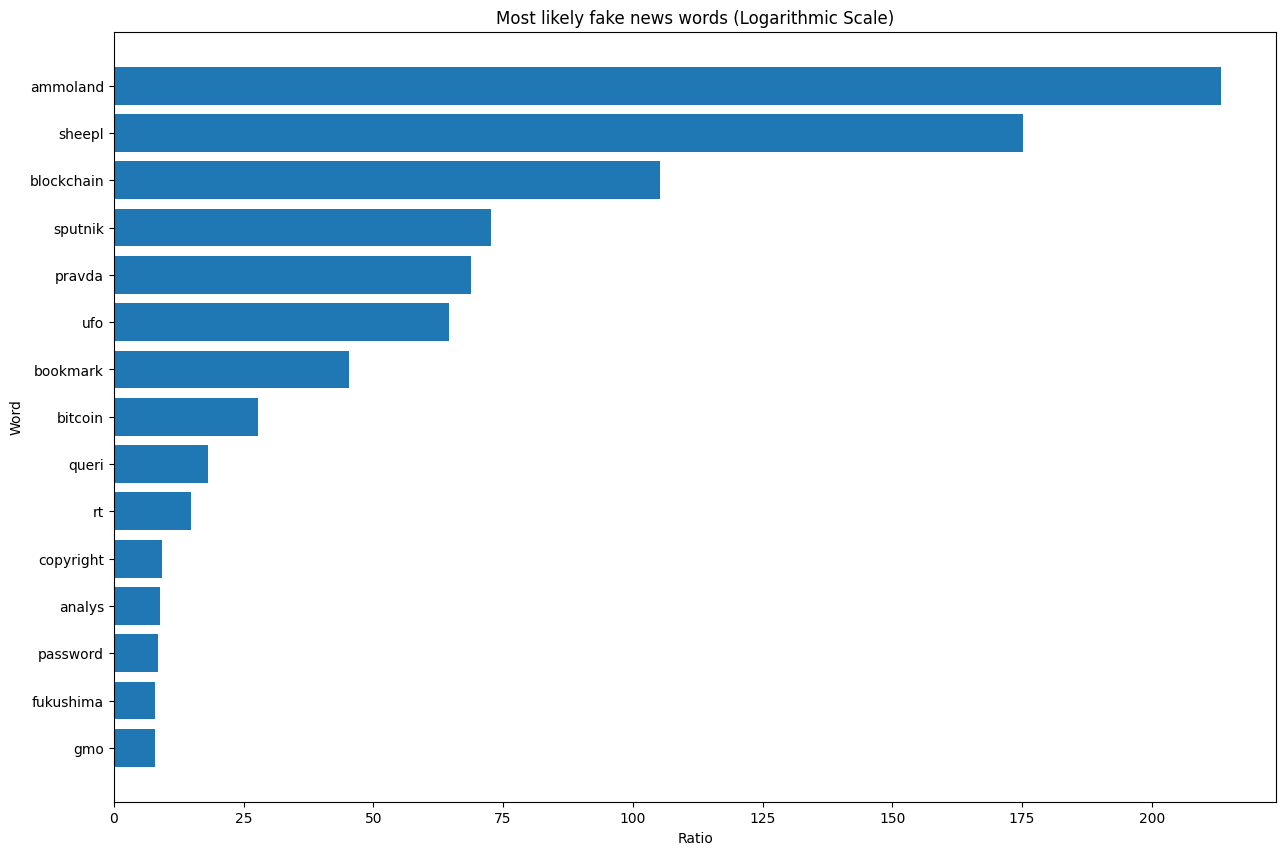

In [43]:
# Matplot lib the two:
import matplotlib.pyplot as plt

# Sort the words by their ratio:
sorted_ratios = sorted(word_ratios.items(), key=lambda x: x[1])

# Get the 10 most likely fake news words:

fake_words = sorted_ratios[-15:]

# Plot:
plt.figure(figsize=(15, 10))
plt.barh([word for word, ratio in fake_words], [ratio for word, ratio in fake_words])

plt.title('Most likely fake news words (Logarithmic Scale)')
plt.xlabel('Ratio')
plt.ylabel('Word')
plt.show()


In [84]:
# most fake domains, and most real domains:

# Calculate the frequency of each domain in each type:
import re


fake_domains = fake_news['domain'].value_counts()
junk_domains = junk_news['domain'].value_counts()
real_domains = real_news['domain'].value_counts()

print('Fake domains:', len(fake_domains))
print('Junk domains:', len(junk_domains))
print('Real domains:', len(real_domains))

# take only the base. So remove the www. and the .com, and any get parameters, as well as anything else.
# i.e., stuff like "www.old.cnn.com/articles/category?=news#top" should be "cnn.com"
pattern = r'(?:www\.)?([^/]+)\..*'	# match the domain name

def clean_domain(domain):
    match = re.match(pattern, domain)
    if match:
        return match.group(1)
    else:
        print("No match for", domain)
    return domain

fake_domains.index = fake_domains.index.map(clean_domain)
junk_domains.index = junk_domains.index.map(clean_domain)
real_domains.index = real_domains.index.map(clean_domain)


# Calculate the ratio of the frequency of the domain in fake news to the frequency of the domain in real news:
domain_ratios = {}

for domain in set(fake_domains.index) | set(real_domains.index):
    fake_count_series = fake_domains.loc[[domain]] if domain in fake_domains.index else pd.Series([0])
    real_count_series = real_domains.loc[[domain]] if domain in real_domains.index else pd.Series([0])
    fake_count = fake_count_series.iloc[0] if not fake_count_series.empty else 0
    real_count = real_count_series.iloc[0] if not real_count_series.empty else 0
    if real_count > 0 and fake_count > 0:
        #print("Domain:", domain, "Fake count:", fake_count, "Real count:", real_count)
        domain_ratios[domain] = fake_count / real_count
    #else:
        #print(domain, fake_count, real_count)



Fake domains: 271
Junk domains: 77
Real domains: 134


In [91]:
# Average entropy of fake news urls and real news urls:
import numpy as np
from scipy.stats import entropy

#dask:
import dask.dataframe as dd

# client:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=16, threads_per_worker=1, memory_limit='4GB')
client = Client(cluster)

def calculate_entropy(url):
    """Calculate the Shannon entropy of a string."""
    # Count the frequency of each character in the URL
    char_counts = np.array(list(map(url.count, set(url))))
    # Calculate the probabilities for each unique character
    probabilities = char_counts / char_counts.sum()
    # Calculate and return the Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def calculate_avg_entropy(data):
    """Calculate the average entropy of the URLs in the dataset."""
    # Calculate the entropy of each URL
    entropies = data['url'].apply(calculate_entropy)
    # Calculate the average entropy
    #avg_entropy = entropies.mean().compute()
    #no attribute compute() for dask dataframe:
    avg_entropy = entropies.mean()
    return avg_entropy


fake_entropy = calculate_avg_entropy(fake_news)
print('Fake news entropy:', fake_entropy)
real_entropy = calculate_avg_entropy(real_news)
print('Real news entropy:', real_entropy)


c:\.KU\Grundlæggende Data Science\Eksamen\.venv\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55027 instead
  warnings.warn(
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2032.0_x64__qbz5n2kfra8p0\lib\contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.01s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Fake news entropy: 4.4463662655549765
Real news entropy: 4.535503524672251


above is not interesting.

In [99]:
# Differences in punctuation usage between fake news and real news.
# We will only be looking at the following punctuation marks: . , ! ? : ; " ' ( ) [ ] { }

# Calculate the frequency of each punctuation mark in each type:
def count_punctuation(data):
    punctuation = Counter()
    for text in data['tokens']:
        if isinstance(text, float):
            print(text)
            continue
        for char in text:
            if char in '.,!?;:"\'()[]{}':
                punctuation[char] += 1
    return punctuation

fake_punctuation = count_punctuation(fake_news)
print('Fake news punctuation:', fake_punctuation)
real_punctuation = count_punctuation(real_news)
print('Real news punctuation:', real_punctuation)

# Calculate the ratio of the frequency of the punctuation mark in fake news to the frequency of the punctuation mark in real news:
#punctuation_ratios = {char: fake_punctuation[char] / real_punctuation[char] for char in fake_punctuation if real_punctuation[char] > 0}
# compensate for different sizes of the datasets:
punctuation_ratios = {char: (fake_punctuation[char] / len(fake_news)) / (real_punctuation[char] / len(real_news)) for char in fake_punctuation if real_punctuation[char] > 0}



Fake news punctuation: Counter({'.': 7255613, ',': 7241601, '"': 2405359, "'": 2181362, ':': 815113, ')': 738522, '(': 723807, '?': 385315, '!': 219442, ';': 149601, ']': 126003, '[': 125935, '{': 12164, '}': 12161})
Real news punctuation: Counter({'.': 12768889, ',': 11636256, "'": 5108210, '"': 3822071, ':': 1109332, ')': 864812, '(': 857450, '?': 422172, ';': 318531, '!': 164639, '[': 105898, ']': 105876, '{': 2182, '}': 2180})


In [94]:
# Average sentence length of fake news and real news:
# We will define a sentence as a sequence of words that ends with a period, question mark, or exclamation point.
# We will calculate the average number of words in each sentence for fake news and real news.

# Calculate the average sentence length of the text:
def calculate_avg_sentence_length(data):
    sentence_lengths = []
    for text in data['tokens']:
        if isinstance(text, float):
            print(text)
            continue
        sentences = re.split(r'[.!?]', text)
        sentence_lengths.extend([len(sentence.split()) for sentence in sentences if sentence])
    return sum(sentence_lengths) / len(sentence_lengths)

fake_sentence_length = calculate_avg_sentence_length(fake_news)
print('Fake news sentence length:', fake_sentence_length)
real_sentence_length = calculate_avg_sentence_length(real_news)
print('Real news sentence length:', real_sentence_length)


Fake news sentence length: 12.231049688572387
Real news sentence length: 11.15541190270877


In [108]:
# Print the 10 punctuation marks with the highest ratio:
print("Most likely fake news punctuation:")
print(sorted(punctuation_ratios.items(), key=lambda x: x[1], reverse=True)[:10])

# Print the 10 punctuation marks with the lowest ratio:
print("Most likely real news punctuation:")
#print(sorted(punctuation_ratios.items(), key=lambda x: x[1])[:10])
# take reciprocal when printing:
sorted_items = sorted(punctuation_ratios.items(), key=lambda x: x[1])[:10]
# Now, transform each item by taking the reciprocal of the ratio.
reciprocals = [(key, 1/value) for key, value in sorted_items]
# Finally, print the transformed list.
print(reciprocals)

Most likely fake news punctuation:
[('}', 6.680648045642687), ('{', 6.676171168630033), ('!', 1.596220304580892), (']', 1.4252437911974256), ('[', 1.4241786998806336), ('?', 1.0930305179853208), (')', 1.0226982849433224), ('(', 1.0109269441282251), (':', 0.8799582683651983), ('"', 0.7536799315415555)]
Most likely real news punctuation:
[("'", 1.9553981587878282), (';', 1.7779167061151528), ('.', 1.4695122261647136), (',', 1.3417539340027476), ('"', 1.3268231753957258), (':', 1.1364175279105193), ('(', 0.9891911634251197), (')', 0.9778054923162599), ('?', 0.9148875384039641), ('[', 0.7021590760231242)]


In [109]:
# Average text entropy of the rich tokens of fake news and real news:
# Calculate the average entropy of the text in each type:
def calculate_entropy(text):
    """Calculate the Shannon entropy of a string."""
    # Count the frequency of each character in the text
    char_counts = np.array(list(map(text.count, set(text))))
    # Calculate the probabilities for each unique character
    probabilities = char_counts / char_counts.sum()
    # Calculate and return the Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def calculate_avg_entropy(data):
    """Calculate the average entropy of the text in the dataset."""
    # Calculate the entropy of each text
    entropies = data['rich_tokens'].apply(calculate_entropy)
    # Calculate the average entropy
    avg_entropy = entropies.mean()
    return avg_entropy


fake_entropy = calculate_avg_entropy(fake_news)
print('Fake news entropy:', fake_entropy)
real_entropy = calculate_avg_entropy(real_news)
print('Real news entropy:', real_entropy)

Fake news entropy: 4.193827472606866
Real news entropy: 4.2866780691085875
